In [1]:
#!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-Levenshtein]


In [2]:
import pandas as pd
import ast

#working_dir = 'C:/Users/carja/Documents/Capstone/data/'
working_dir = '/mnt/c/Users/carja/Documents/Capstone/data/'
df = pd.read_csv(working_dir + 'analyzedTracks.csv')

# remove playlist related columns
df = df.drop(columns=['pos','playlist_num_albums','playlist_num_artists','playlist_num_followers','playlist_collaborative','playlist_pid','album_name','playlist_num_tracks','playlist_name','duration_ms','playlist_pid'])

#split mfcc_shape into x & y size
def unpack_shape(value):
    try:
        if isinstance(value, str):
            value = ast.literal_eval(value)  # convert string to tuple
        if isinstance(value, tuple) and len(value) == 2:
            return value
    except Exception:
        pass
    return (None, None)

df[['mfcc_shape_x', 'mfcc_shape_y']] = df['mfcc_shape'].apply(unpack_shape).apply(pd.Series)
df.drop(columns=['mfcc_shape'], inplace=True)

# remove rows w/out a progression -- most likely audio was correct or absent
df = df.dropna(subset=['progression1'])
#remove duplicate tracks
df = df.drop_duplicates(subset=['artist_name', 'track_name'])

# Store track_name and artist_name separately
meta_cols = df[['track_name', 'artist_name']].copy()
df_cleaned = df.drop(['track_name', 'artist_name'], axis=1)
df_cleaned.head()


,harmony_degree,tonic,mode,tempo,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var,progression1,progression2,mfcc_shape_x,mfcc_shape_y
0,6.297153,F,major,129.199219,21.106346,11.337712,2640.301228,890.561052,0.083839,0.205738,"['v', 'vi', 'ii', 'iio', 'bVII', 'vi', 'ii', 'I']","['ii', 'I', 'bVII', 'ii', 'iio', 'bVII', 'ii',...",13.0,7656.0
1,6.791351,A,major,161.499023,21.820560,11.282618,2693.961413,1082.618798,0.036503,0.072091,"['i', 'iv', 'i', 'iio']","['iv', 'i', 'iio', 'i']",13.0,10429.0
2,5.641401,A,minor,143.554688,21.415842,11.880545,2628.981838,809.000785,0.048472,0.124956,"['iv', 'bVII', 'i', 'iv', 'bVII', 'i']","['i', 'iv', 'bVII', 'i', 'iv']",13.0,9565.0
3,8.635023,A,minor,143.554688,21.660702,11.768187,3254.803701,926.430375,0.066690,0.099132,"['bVI', 'v', 'bVI', 'v', 'bVI', 'v']","['V', 'bVII', 'V', 'bVII', 'i', 'I', 'iio', 'I']",13.0,10439.0
4,5.192371,E,major,135.999178,23.254460,10.982775,2546.516052,884.615807,0.038849,0.126105,"['IV', 'V', 'biv', 'I']","['I', 'vi', 'IV', 'V', 'biv']",13.0,9648.0


In [3]:
#Normalize numerical features
from sklearn.preprocessing import StandardScaler

num_cols = ['harmony_degree', 'tempo', 'mfcc_shape_x', 'mfcc_shape_y', 'spectral_contrast_mean', 'spectral_contrast_var',
            'spectral_centroid_mean', 'spectral_centroid_var',
            'spectral_flatness_mean', 'spectral_flatness_var']
scaler = StandardScaler()
X_num = scaler.fit_transform(df_cleaned[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols, index=df_cleaned.index)
X_num_df.head()

,harmony_degree,tempo,mfcc_shape_x,mfcc_shape_y,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var
0,1.023115,0.385564,0.0,-0.667090,-1.344018,-0.266460,0.690353,0.405695,1.892069,2.033252
1,1.344542,1.662400,0.0,-0.056772,-0.739853,-0.341703,0.798901,1.356856,0.092205,-0.177993
2,0.596614,0.953047,0.0,-0.246933,-1.082210,0.474896,0.667455,0.001769,0.547286,0.696690
3,2.543668,0.953047,0.0,-0.054571,-0.875079,0.321448,1.933422,0.583337,1.239999,0.269416
4,0.304564,0.654372,0.0,-0.228665,0.473107,-0.751204,0.500636,0.376251,0.181390,0.715690


In [4]:
#One Hot Encode Categoricals
X_cat = pd.get_dummies(df_cleaned[['tonic', 'mode']])

X_cat_df = pd.DataFrame(X_cat, columns=['tonic', 'mode'], index=df_cleaned.index)
X_cat.head()

,tonic_A,tonic_A#,tonic_B,tonic_C,tonic_C#,tonic_D,tonic_D#,tonic_E,tonic_F,tonic_F#,tonic_G,tonic_G#,mode_major,mode_minor
0,False,False,False,False,False,False,False,False,True,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,False,False,False,True,False


In [17]:
import ast
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from itertools import combinations
from functools import partial
import re

# Mapping from roman base to chromatic index (C=1)
BASE_ROMAN_TO_NUM = {
    'i': 0, 'ii': 2, 'iii': 4, 'iv': 5,
    'v': 7, 'vi': 9, 'vii': 11
}

def roman_to_num(roman):
    if not isinstance(roman, str):
        return None

    roman = roman.lower().strip()
    match = re.fullmatch(r'([b#]*)(i{1,3}|iv|v|vi{0,2}|vii)', roman)
    if not match:
        return None

    modifiers, base = match.groups()
    base_val = BASE_ROMAN_TO_NUM.get(base)
    if base_val is None:
        return None

    offset = sum(1 if ch == '#' else -1 for ch in modifiers)
    return (base_val + offset) % 12

def circular_distance(n1, n2):
    return min((n1 - n2) % 12, (n2 - n1) % 12)


def progression_distance(prog1, prog2):
    nums1 = [roman_to_num(r) for r in prog1 if roman_to_num(r) is not None]
    nums2 = [roman_to_num(r) for r in prog2 if roman_to_num(r) is not None]

    if not nums1 or not nums2:
        return 1.0  # Maximum normalized distance

    # Identify shorter and longer sequence
    if len(nums1) <= len(nums2):
        short, long_ = nums1, nums2
    else:
        short, long_ = nums2, nums1

    len_short = len(short)

    # Exact length match
    if len_short == len(long_):
        total_dist = sum(circular_distance(short[i], long_[i]) for i in range(len_short))
        return (total_dist / len_short) / 6.0

    # Subsequence matching
    min_avg = float('inf')
    for offset in range(len(long_) - len_short + 1):
        window = long_[offset:offset + len_short]
        avg_dist = sum(circular_distance(short[i], window[i]) for i in range(len_short)) / len_short
        min_avg = min(min_avg, avg_dist)

    return min_avg / 6.0


def compute_pairwise_distance(pair, cached_progs):
    i, j = pair
    prog1_i, prog2_i = cached_progs[i]
    prog1_j, prog2_j = cached_progs[j]

    d1 = progression_distance(prog1_i, prog1_j)
    d2 = progression_distance(prog2_i, prog2_j)
    d3 = progression_distance(prog1_i, prog2_j)
    d4 = progression_distance(prog2_i, prog1_j)

    min_dist = min(d1, d2, d3, d4)
    return (i, j, min_dist)


def compute_progression_distance_matrix(df):
    n = len(df)
    dist_matrix = np.zeros((n, n))

    # Pre-parse and cache progressions
    cached_progs = [
        (parse_progression(row['progression1']), parse_progression(row['progression2']))
        for _, row in df.iterrows()
    ]

    # Generate all unique i < j pairs
    pairs = list(combinations(range(n), 2))

    # Use parallel processing
    with ThreadPoolExecutor() as executor:
        for i, j, dist in executor.map(partial(compute_pairwise_distance, cached_progs=cached_progs), pairs):
            dist_matrix[i, j] = dist_matrix[j, i] = dist

    return dist_matrix


# Embed to N-dimensional space (e.g., 2D or 5D)
D_prog = compute_progression_distance_matrix(df_cleaned)
D_prog = np.nan_to_num(D_prog, nan=0)

# Sanity checks
assert np.all(D_prog >= 0)
assert np.allclose(np.diag(D_prog), 0)
assert np.allclose(D_prog, D_prog.T)

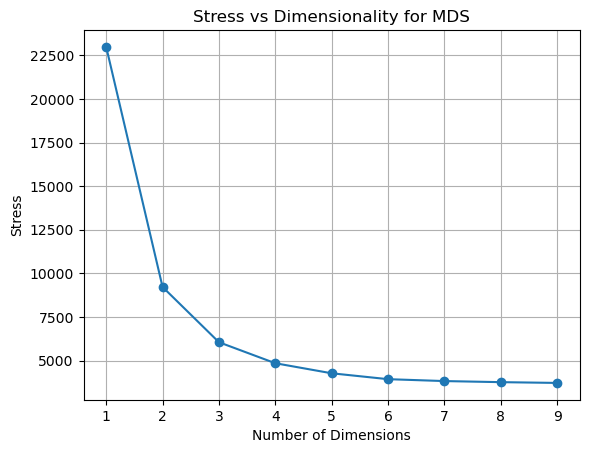

In [18]:
from sklearn.manifold import MDS

#Stress test the dimensionality reduction to choose the right dimension
stress_values = []
dimensions = range(1, 10)
for dim in dimensions:
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=42)
    mds.fit(D_prog)
    stress_values.append(mds.stress_)

import matplotlib.pyplot as plt

plt.plot(dimensions, stress_values, marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Stress')
plt.title('Stress vs Dimensionality for MDS')
plt.grid(True)
plt.show()

In [19]:
# build the matrix
embedding = MDS(n_components=4, dissimilarity='precomputed', random_state=42) #use multi-dimensional scaling to compress into a lower dimensional space
prog_embedded = embedding.fit_transform(D_prog) # an N×3 matrix where each row is a 4D coordinate embedding of a data point.

scaler = StandardScaler()
prog_embedded_scaled = scaler.fit_transform(prog_embedded)

print(prog_embedded_scaled[:5])  # Show first 5 rows

[[ 1.54638965  0.75927148 -1.5138531   1.0194209 ]
 [ 0.08919154  0.72491901  0.42609395  0.3020241 ]
 [ 1.49968565 -1.15894051  0.41186701  0.33309227]
 [-0.65479365 -1.08026985 -1.52925252  1.51195148]
 [-0.82907479 -0.06489706 -0.27661808 -1.83416384]]


In [20]:
from sklearn.decomposition import TruncatedSVD

"""
Prints the top `top_features_per_factor` contributing features for the first `top_n` SVD components.
"""
def print_top_svd_factors(svd, feature_names, top_n=5):
    for i in range(min(top_n, svd.components_.shape[0])):
        component = svd.components_[i]
        top_indices = np.argsort(np.abs(component))[::-1]
        top_features = [(feature_names[j], component[j]) for j in top_indices]

        print(f"\nSVD Factor {i+1}:")
        for name, weight in top_features:
            print(f"  {name}: {weight:.4f}")

# ideally we'd use Grid Search to find optimal weights but judging the outcome is subjective so we're limited to an unsupervised approach
# these get diluted by the SVD anyway so aren't so important
w_num = 0.15     # weight for spectral/numerical features
w_cat = 0.15   # weight for categorical features
w_prog = 0.7   # weight for progression embeddings

X_total = np.hstack([
    X_num * w_num,
    X_cat * w_cat,
    prog_embedded * w_prog
])
svd = TruncatedSVD(n_components=10)
X_reduced = svd.fit_transform(X_total)

## Assemble the column names
# Numeric column names
num_col_names = list(df_cleaned[num_cols].columns)
# Categorical column names
cat_col_names = list(X_cat.columns)
# Progression embedding column names
prog_col_names = [f'prog_embedded_{i}' for i in range(prog_embedded.shape[1])]
feature_names = num_col_names + cat_col_names + prog_col_names

print_top_svd_factors(svd, feature_names, top_n=5)


SVD Factor 1:
  spectral_flatness_mean: 0.5152
  spectral_contrast_mean: -0.4871
  spectral_centroid_mean: 0.4126
  harmony_degree: 0.3982
  spectral_flatness_var: 0.3392
  spectral_centroid_var: 0.1911
  spectral_contrast_var: 0.1022
  mode_major: -0.0549
  mode_minor: 0.0514
  tempo: 0.0170
  prog_embedded_0: 0.0098
  prog_embedded_3: 0.0085
  tonic_D: -0.0084
  prog_embedded_1: -0.0084
  tonic_F: -0.0074
  tonic_A: 0.0073
  mfcc_shape_y: -0.0059
  prog_embedded_2: -0.0048
  tonic_G: 0.0046
  tonic_G#: -0.0046
  tonic_B: 0.0035
  tonic_F#: 0.0035
  tonic_A#: -0.0022
  tonic_D#: 0.0017
  tonic_E: -0.0013
  tonic_C#: -0.0002
  tonic_C: -0.0001
  mfcc_shape_x: -0.0000

SVD Factor 2:
  spectral_flatness_var: 0.5286
  spectral_centroid_var: 0.4613
  harmony_degree: -0.3935
  spectral_contrast_var: -0.3710
  spectral_flatness_mean: 0.2794
  spectral_centroid_mean: -0.2539
  spectral_contrast_mean: 0.2183
  mfcc_shape_y: -0.1232
  mode_major: 0.0549
  mode_minor: -0.0498
  prog_embedded_3:

Best number of clusters: 6


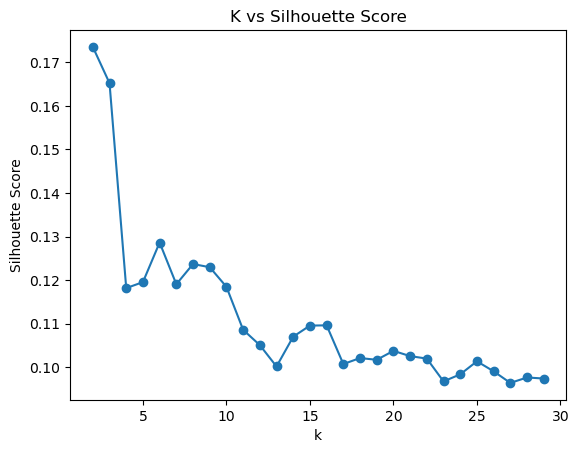

In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

MIN_CLUSTER = 5

def search_best_k(X, k_range=range(2, 21), metric='silhouette'):
    best_k = None
    best_score = -np.inf
    scores = []

    for k in k_range:
        # Cluster the data using KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        # Score clustering quality
        if metric == 'silhouette':
            score = silhouette_score(X, labels)
        elif metric == 'calinski':
            from sklearn.metrics import calinski_harabasz_score
            score = calinski_harabasz_score(X, labels)
        elif metric == 'davies':
            from sklearn.metrics import davies_bouldin_score
            score = -davies_bouldin_score(X, labels)  # negate since lower is better
        else:
            raise ValueError("Unknown metric")

        scores.append((k, score))

        if k > MIN_CLUSTER and score > best_score:
            best_k = k
            best_score = score

    return best_k, scores

# find the K that maximizes grouping among the tracks
best_k, score_list = search_best_k(X_reduced, k_range=range(2, 30), metric='silhouette')
print("Best number of clusters:", best_k)

# Optional: Plot score trend
import matplotlib.pyplot as plt

ks, values = zip(*score_list)
plt.plot(ks, values, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('K vs Silhouette Score')
plt.show()

In [22]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=best_k)
knn.fit(X_reduced)
distances, indices = knn.kneighbors(X_reduced)

In [23]:
# Append artist & title back to the data to handle queries
df_result = pd.concat([df_cleaned, meta_cols], axis=1)
df_result.head()

,harmony_degree,tonic,mode,tempo,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var,progression1,progression2,mfcc_shape_x,mfcc_shape_y,track_name,artist_name
0,6.297153,F,major,129.199219,21.106346,11.337712,2640.301228,890.561052,0.083839,0.205738,"['v', 'vi', 'ii', 'iio', 'bVII', 'vi', 'ii', 'I']","['ii', 'I', 'bVII', 'ii', 'iio', 'bVII', 'ii',...",13.0,7656.0,How I Feel,Flo Rida
1,6.791351,A,major,161.499023,21.820560,11.282618,2693.961413,1082.618798,0.036503,0.072091,"['i', 'iv', 'i', 'iio']","['iv', 'i', 'iio', 'i']",13.0,10429.0,Lo Que No Sabes Tú,Chino & Nacho
2,5.641401,A,minor,143.554688,21.415842,11.880545,2628.981838,809.000785,0.048472,0.124956,"['iv', 'bVII', 'i', 'iv', 'bVII', 'i']","['i', 'iv', 'bVII', 'i', 'iv']",13.0,9565.0,Chucuchá,Ilegales
3,8.635023,A,minor,143.554688,21.660702,11.768187,3254.803701,926.430375,0.066690,0.099132,"['bVI', 'v', 'bVI', 'v', 'bVI', 'v']","['V', 'bVII', 'V', 'bVII', 'i', 'I', 'iio', 'I']",13.0,10439.0,Mueva la colita,Various Artists
4,5.192371,E,major,135.999178,23.254460,10.982775,2546.516052,884.615807,0.038849,0.126105,"['IV', 'V', 'biv', 'I']","['I', 'vi', 'IV', 'V', 'biv']",13.0,9648.0,Be My Baby,Leslie Grace


In [24]:
import random

def recommend_tracks(track_index, distances, indices, track_info, n_recs):
    recs = []
    for i in range(1, min(n_recs + 1, len(indices[track_index]))):  # Skip index 0 (the track itself)
        idx = indices[track_index][i]
        recs.append({
            'track_name': track_info.iloc[idx]['track_name'],
            'artist_name': track_info.iloc[idx]['artist_name'],
            'distance': distances[track_index][i]
        })
    return recs

def recommendation(artist, track, df):
    match = df[(df['artist_name'] == artist) & (df['track_name'] == track)]
    # Get index
    if not match.empty:
        track_index = match.index[0]  # or list(match.index) if multiple
        print(f"track index {track_index}")
        return recommend_tracks(track_index, distances, indices, df, best_k)
    else:
        return None

def random_recommendation(df):
    while True:
        try:
            track_index = random.randint(0, len(df) - 1)  # Corrected upper bound
            artist = df.loc[track_index, 'artist_name']
            track = df.loc[track_index, 'track_name']
            result = recommendation(artist, track, df)
            return result, artist, track
        except KeyError:
            continue  # Retry on KeyError

# handle a specific inquiry
recs = recommendation('natori', 'IN_MY_HEAD', df_result)
print(f"Recommendation for: 'IN_MY_HEAD' by 'natori'")
for rec in recs:
    print(f"   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")

recs = recommendation('Flo Rida', 'How I Feel', df_result)
print(f"\nRecommendation for: 'How I Feel' by 'Flo Rida'")
for rec in recs:
    print(f"   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")

#make a random recommendation
recs, artist, track = random_recommendation(df_result)
print(f"\nRecommendation for: '{track}' by '{artist}'")
for rec in recs:
    print(f"   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")


track index 675
Recommendation for: 'IN_MY_HEAD' by 'natori'
   I Bet My Life - Alex Adair Remix by Imagine Dragons (distance: 0.217)
   Ram Jam - Black Betty by RamJamVEVO (distance: 0.244)
   Promiscuous by Nelly Furtado (distance: 0.253)
   RUN DMC - You Talk Too Much (Official Video) by Run DMC (distance: 0.257)
   Groove Theory - Tell Me (Official HD Video) by GrooveTheoryVEVO (distance: 0.258)
track index 0

Recommendation for: 'How I Feel' by 'Flo Rida'
   Timber by Pitbull (distance: 0.144)
   逆光 by Ado (distance: 0.165)
   Let's Fall in Love Some More by Al Bairre (distance: 0.185)
   Hella décalé (feat. Soldat Jahman & Doukali) by Dj Mam's (distance: 0.192)
   Can I Play with Madness (2015 Remaster) by Iron Maiden (distance: 0.202)
track index 678

Recommendation for: 'モルト' by 'Lavt'
   Jocelyn Flores by XXXTENTACION (distance: 0.197)
   No Type by Rae Sremmurd (distance: 0.217)
   Summers Over Interlude by Drake (distance: 0.259)
   ILLIT (아일릿) ‘Magnetic’ Official MV by HYBE

In [25]:
def group_recommendations_by_track(indices, distances, track_info, best_k):
    def safe_get(row, key, default=''):
        value = row.get(key, default)
        return default if pd.isnull(value) else value

    track_recommendations = {}

    for _, row in track_info.iterrows():
        if pd.isnull(row.get('artist_name')) or pd.isnull(row.get('track_name')):
            continue

        match = track_info[
            (track_info['artist_name'] == row['artist_name']) &
            (track_info['track_name'] == row['track_name'])
        ]
        if match.empty:
            continue

        track_index = match.index[0]
        if track_index >= len(indices):
            continue

        recs = []
        for i in range(1, min(best_k + 1, len(indices[track_index]))):  # Skip index 0 (the track itself)
            idx = indices[track_index][i]
            if idx >= len(track_info):
                continue

            rec_row = track_info.iloc[idx]
            if pd.isnull(rec_row.get('track_name')) or pd.isnull(rec_row.get('artist_name')):
                continue

            recs.append({
                'track_name': safe_get(rec_row, 'track_name'),
                'artist_name': safe_get(rec_row, 'artist_name'),
                'harmony_degree': safe_get(rec_row, 'harmony_degree', None),
                'tonic': safe_get(rec_row, 'tonic', None),
                'mode': safe_get(rec_row, 'mode', None),
                'tempo': safe_get(rec_row, 'tempo', None),
                'progression1': safe_get(rec_row, 'progression1'),
                'progression2': safe_get(rec_row, 'progression2'),
                'distance': distances[track_index][i]
            })

        if not recs:
            continue

        track_key = f"{row['artist_name']} - {row['track_name']}"
        track_recommendations[track_key] = {
            'track_name': safe_get(row, 'track_name'),
            'artist_name': safe_get(row, 'artist_name'),
            'harmony_degree': safe_get(row, 'harmony_degree', None),
            'tonic': safe_get(row, 'tonic', None),
            'mode': safe_get(row, 'mode', None),
            'tempo': safe_get(row, 'tempo', None),
            'progression1': safe_get(row, 'progression1'),
            'progression2': safe_get(row, 'progression2'),
            'recommendations': recs
        }

    return track_recommendations


res = group_recommendations_by_track(indices, distances, df_result, best_k)

# Print first 10 entries
#for i, record in enumerate(res.items()):
#    if i >= 5:
#        break
#    print(f"\n{record}\n")

In [26]:
import json

# Save to JSON file
with open('../frontend/public/grouped_recommendations.json', 'w', encoding='utf-8') as f:
    json.dump(res, f, indent=2, ensure_ascii=False)
